#### Import Libraries

In [1]:
# math, dataframe, visualization
import numpy                  as np
import pandas                 as pd
import matplotlib.pyplot      as plt
import seaborn                as sns
# Import financial libraries
import yfinance               as yf
import pandas_ta              as ta

# sklearn
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.pipeline         import Pipeline
from sklearn.preprocessing    import MinMaxScaler
from sklearn.linear_model     import LinearRegression, Lasso, Ridge
from sklearn.neighbors        import KNeighborsRegressor
from sklearn.svm              import SVR
from sklearn.ensemble         import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics          import mean_squared_error

# LSTM
from keras.models                 import Sequential
from keras.layers                 import Dense, LSTM
from keras.callbacks              import History
from keras.utils.vis_utils        import plot_model
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras             import regularizers
from keras.callbacks              import EarlyStopping
# Save model to disk
import joblib

#### Hands on data and EDA

In [2]:
# Data request from Yahoo Finance
data = yf.download(tickers='EURUSD=X', start='2000-01-01', end='2022-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01 00:00:00+00:00,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02 00:00:00+00:00,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03 00:00:00+00:00,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04 00:00:00+00:00,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05 00:00:00+00:00,1.207802,1.219096,1.206593,1.218695,1.218695,0


In [3]:
# Change index format
data.index = pd.to_datetime(data.index, format = '%Y-%m-%d').strftime('%Y-%m-%d')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0


In [4]:
# Adding indicators
data['RSI']  = ta.rsi(data.Close, length=14)
data['EMAF'] = ta.ema(data.Close, length=21)
data['EMAM'] = ta.ema(data.Close, length=50)
data['EMAS'] = ta.ema(data.Close, length=100)

# Add column 'NextClose' for next close price
data['NextClose'] = data['Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
data.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,NextClose
0,1.198796,1.204805,1.193104,1.200293,41.059086,1.212556,1.225697,1.240527,1.200696
1,1.201995,1.207802,1.200293,1.200696,41.325468,1.211478,1.224716,1.239739,1.184806
2,1.198796,1.201995,1.182802,1.184806,34.680444,1.209054,1.223151,1.238651,1.181000
3,1.184806,1.191199,1.182103,1.181000,33.299369,1.206503,1.221498,1.237509,1.192506
4,1.180693,1.193104,1.179106,1.192506,40.954946,1.205231,1.220361,1.236618,1.185003


#### Feature Selection and Train/Test split

In [5]:
# Set featuer variable and target variable
X = data[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAM', 'EMAS']]
y = data['NextClose']

In [6]:
# Train/Test split 80/20
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.2)

#### Supervised Machine Learning

In [7]:
def pred_viz(y_pred):
    ''' Visualization function for 
        Train, Test, and Prediction data'''
    plt.figure(figsize=(12,5))
    y_train.plot(label='TrainData')
    y_test.plot(label='TestData')
    pd.Series(y_pred,y_test.index).plot(label='Prediction',alpha=0.75)
    plt.legend();

BestScore:  0.97875
MSE Score:  1e-05
RMSE Score: 0.00377


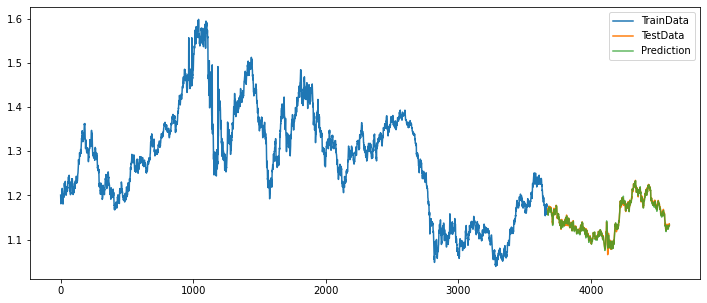

In [8]:
# Linear Regression with pipline and gridsearch
pipe1 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('lr',LinearRegression())])
grid1 = GridSearchCV(pipe1, param_grid={})
grid1.fit(X_train,y_train)
y_pred1 = grid1.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = mean_squared_error(y_test, y_pred1, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid1.best_score_.round(5)}')
print(f'MSE Score:  {mse1.round(5)}')
print(f'RMSE Score: {rmse1.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred1)

BestScore:  -0.08354
BestParams: {'ls__alpha': 0.01}
MSE Score:  0.00292
RMSE Score: 0.05402


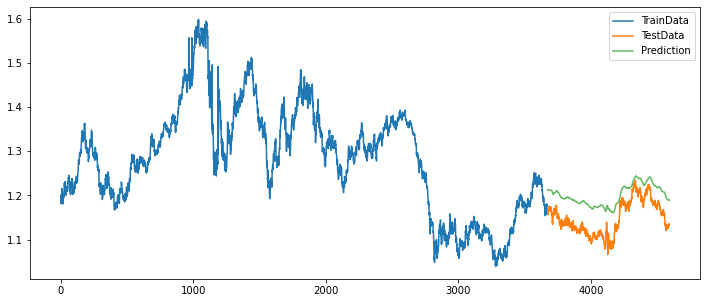

In [9]:
# Lasso with pipeline and gridsearch
pipe2 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('ls',Lasso())])
params2 = {'ls__alpha': [.01,.1,1,10]}
grid2 = GridSearchCV(pipe2,param_grid=params2)
grid2.fit(X_train,y_train)
y_pred2 = grid2.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = mean_squared_error(y_test, y_pred2, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid2.best_score_.round(5)}')
print(f'BestParams: {grid2.best_params_}')
print(f'MSE Score:  {mse2.round(5)}')
print(f'RMSE Score: {rmse2.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred2)

BestScore:  0.97905
BestParams: {'rg__alpha': 0.1}
MSE Score:  2e-05
RMSE Score: 0.00397


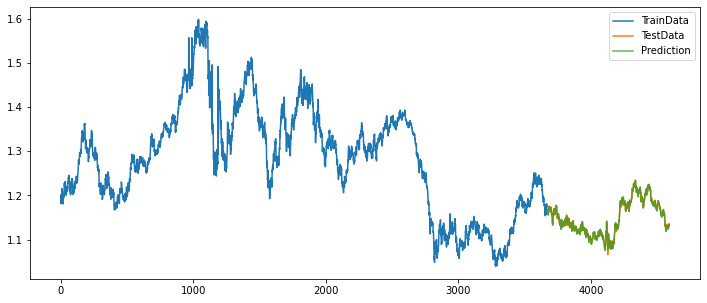

In [10]:
# Ridge with pipeline and gridsearch
pipe3 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('rg',Ridge())])
params3 = {'rg__alpha': [.01,.1,1,10]}
grid3 = GridSearchCV(pipe3,param_grid=params3)
grid3.fit(X_train,y_train)
y_pred3 = grid3.predict(X_test)
mse3 = mean_squared_error(y_test, y_pred3)
rmse3 = mean_squared_error(y_test, y_pred3, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid3.best_score_.round(5)}')
print(f'BestParams: {grid3.best_params_}')
print(f'MSE Score:  {mse3.round(5)}')
print(f'RMSE Score: {rmse3.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred3)

BestScore:  0.91113
BestParams: {'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
MSE Score:  4e-05
RMSE Score: 0.00647


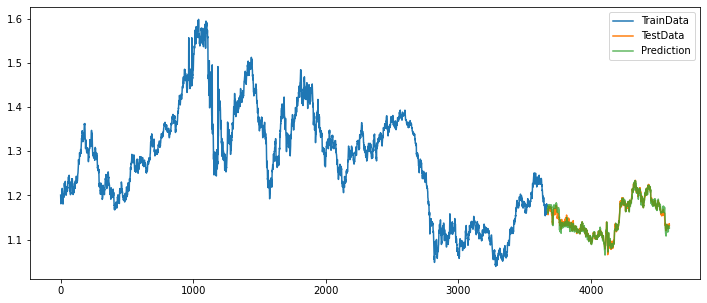

In [11]:
# K-nearest neighbors with pipeline and gridsearch
pipe4 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('knn',KNeighborsRegressor())])
params4 = {'knn__n_neighbors': range(2,7,1),
           'knn__weights':     ['uniform','distance'],
           'knn__algorithm':   ['auto', 'ball_tree', 'kd_tree'],
           'knn__p':           [1,2]}
grid4 = GridSearchCV(pipe4,param_grid=params4)
grid4.fit(X_train,y_train)
y_pred4 = grid4.predict(X_test)
mse4 = mean_squared_error(y_test, y_pred4)
rmse4 = mean_squared_error(y_test, y_pred4, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid4.best_score_.round(5)}')
print(f'BestParams: {grid4.best_params_}')
print(f'MSE Score:  {mse4.round(5)}')
print(f'RMSE Score: {rmse4.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred4)

BestScore:  0.65204
BestParams: {'svr__C': 10, 'svr__degree': 2, 'svr__kernel': 'poly'}
MSE Score:  0.00036
RMSE Score: 0.01893


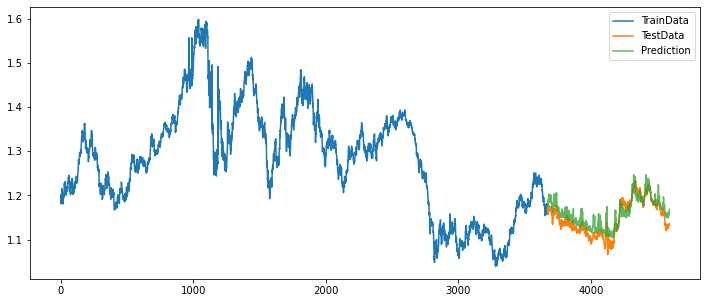

In [12]:
# Support Vector Regression pipeline and gridsearch
pipe5 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('svr',SVR())])
params5 = {'svr__kernel':   ['linear', 'poly', 'rbf', 'sigmoid'],
           'svr__degree':   [2,3,4],
           'svr__C':        [0.01,0.1,1,10]}
grid5 = GridSearchCV(pipe5,param_grid=params5)
grid5.fit(X_train,y_train)
y_pred5 = grid5.predict(X_test)
mse5 = mean_squared_error(y_test, y_pred5)
rmse5 = mean_squared_error(y_test, y_pred5, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid5.best_score_.round(5)}')
print(f'BestParams: {grid5.best_params_}')
print(f'MSE Score:  {mse5.round(5)}')
print(f'RMSE Score: {rmse5.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred5)

BestScore:  0.9491
BestParams: {'rf__bootstrap': True, 'rf__criterion': 'squared_error', 'rf__max_features': None, 'rf__random_state': 80}
MSE Score:  1e-05
RMSE Score: 0.00367


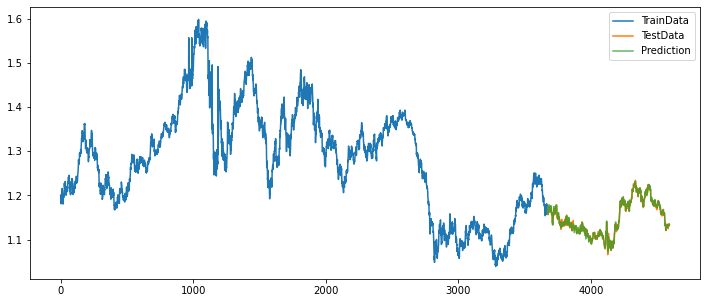

In [13]:
# RandomForest with pipeline and gridsearch
pipe6 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('rf',RandomForestRegressor())])
params6 = {'rf__criterion':    ["squared_error", "absolute_error", "poisson"],
           'rf__max_features': ["sqrt", "log2", None],
           'rf__bootstrap':    [True,False],
           'rf__random_state': range(40,100,20)}
grid6 = GridSearchCV(pipe6,param_grid=params6)
grid6.fit(X_train,y_train)
y_pred6 = grid6.predict(X_test)
mse6 = mean_squared_error(y_test, y_pred6)
rmse6 = mean_squared_error(y_test, y_pred6, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid6.best_score_.round(5)}')
print(f'BestParams: {grid6.best_params_}')
print(f'MSE Score:  {mse6.round(5)}')
print(f'RMSE Score: {rmse6.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred6)

BestScore:  0.94626
BestParams: {'gb__alpha': 0.5, 'gb__learning_rate': 0.1, 'gb__max_features': 6}
MSE Score:  1e-05
RMSE Score: 0.00376


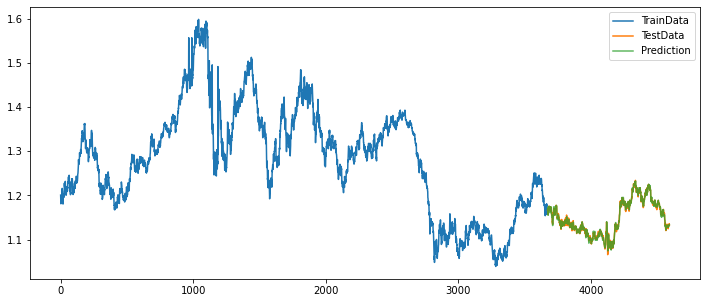

In [14]:
# GradientBoost with pipeline and gridsearch
pipe7 = Pipeline([('sc',MinMaxScaler(feature_range=(0,1))),('gb',GradientBoostingRegressor())])
params7 = {'gb__learning_rate': [.0001,.001,.01,.1],
           'gb__max_features':  range(1,8,1),
           'gb__alpha':         [.1,.3,.5,.7,.9]}
grid7 = GridSearchCV(pipe7,param_grid=params7)
grid7.fit(X_train,y_train)
y_pred7 = grid7.predict(X_test)
mse7 = mean_squared_error(y_test, y_pred7)
rmse7 = mean_squared_error(y_test, y_pred7, squared=False)
# --------------------------------------------------------
print(f'BestScore:  {grid7.best_score_.round(5)}')
print(f'BestParams: {grid7.best_params_}')
print(f'MSE Score:  {mse7.round(5)}')
print(f'RMSE Score: {rmse7.round(5)}')
# --------------------------------------------------------
# Visualization
pred_viz(y_pred7)

#### Summary: Supervised Machine Learning

In [15]:
score_list = [grid1.best_score_.round(5),grid2.best_score_.round(5),
              grid3.best_score_.round(5),grid4.best_score_.round(5),
              grid5.best_score_.round(5),grid6.best_score_.round(5),
              grid7.best_score_.round(5)]
mse_list   = [mse1.round(5),mse2.round(5),mse3.round(5),mse4.round(5),
              mse5.round(5),mse6.round(5),mse7.round(5)]
rmse_list  = [rmse1.round(5),rmse2.round(5),rmse3.round(5),rmse4.round(5),
              rmse5.round(5),rmse6.round(5),rmse7.round(5)]
model_list = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 
              'K-Nearest Neighbors', 'SVR', 'Random Forest', 'Gradient Boosting Regressor'] 

In [16]:
supervised = list(zip(model_list,score_list,mse_list,rmse_list))
supervised_sum = pd.DataFrame(supervised, columns=['Model','Best Score','MSE','RMSE'])

In [17]:
supervised_sum.sort_values('Best Score',ascending=False)

,Model,Best Score,MSE,RMSE
2,Ridge Regression,0.97905,0.00002,0.00397
0,Linear Regression,0.97875,0.00001,0.00377
5,Random Forest,0.94910,0.00001,0.00367
6,Gradient Boosting Regressor,0.94626,0.00001,0.00376
3,K-Nearest Neighbors,0.91113,0.00004,0.00647
4,SVR,0.65204,0.00036,0.01893
1,Lasso Regression,-0.08354,0.00292,0.05402


#### Neutal Network Model

In [18]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)

In [19]:
# Initaiate Keras Sequential model
model = Sequential(name='LSTM.Price.Prediction')
# Parameters tuning
model.add(LSTM(128,return_sequences=True, 
               input_shape=(X_train_sc.shape[1],1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(32,activation='elu',kernel_regularizer=regularizers.L2(0.0001)))
model.add(Dense(1,activation='elu'))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.00001))

29/29 [==============================] - 1s 4ms/step
MSE Score:  0.00016
RMSE Score: 0.01272


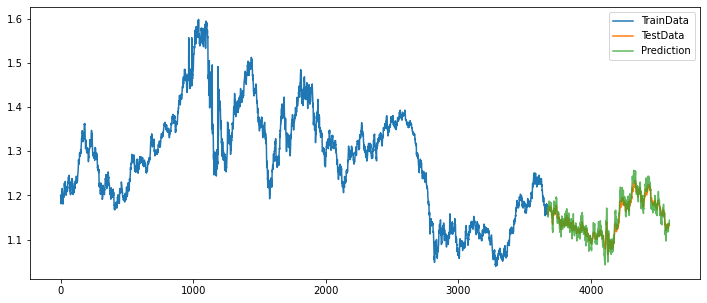

In [20]:
history = model.fit(X_train_sc,y_train,batch_size=30,epochs=100,
                    validation_data=(X_test_sc,y_test),verbose=0)
# Get prediction
y_pred_neu = model.predict(X_test_sc).ravel()
# Change to Series pandas
y_pred_neu = pd.Series(data=y_pred_neu, index=y_test.index)
mse_neu  = mean_squared_error(y_test, y_pred_neu)
rmse_neu = mean_squared_error(y_test, y_pred_neu, squared=False)
# --------------------------------------------------------
print(f'MSE Score:  {mse_neu.round(5)}')
print(f'RMSE Score: {rmse_neu.round(5)}')
# --------------------------------------------------------
# Visualization
plt.figure(figsize=(12,5))
y_train.plot(label='TrainData')
y_test.plot(label='TestData')
y_pred_neu.plot(label='Prediction',alpha=0.75)
plt.legend();

#### Summary LSTM model

In [21]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

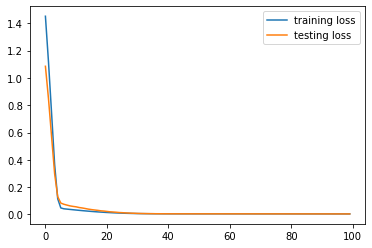

In [22]:
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'], label='testing loss')
plt.legend();

In [23]:
model.summary()

Model: "LSTM.Price.Prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


#### Save models for further usage

In [24]:
# Save machine learning model to disk
filename = 'ridge_model.sav'
joblib.dump(grid3,filename)

['ridge_model.sav']

In [25]:
filename = 'Seq_LSTM_model.sav'
joblib.dump(model,filename)

INFO:tensorflow:Assets written to: ram://b2f7a4c3-f569-448e-b6e8-bdb21565b263/assets


INFO:tensorflow:Assets written to: ram://b2f7a4c3-f569-448e-b6e8-bdb21565b263/assets


['Seq_LSTM_model.sav']